In [68]:
import pandas as pd
import numpy as np
import random as rnd
import re
import pickle

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, balanced_accuracy_score

In [70]:
import mlrose_hiive

In [71]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, 
                        cv=None, scoring='accuracy', n_jobs=None, 
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       scoring=scoring,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")
    axes[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#     # Plot fit_time vs score
#     axes[2].grid()
#     axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
#     axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1)
#     axes[2].set_xlabel("fit_times")
#     axes[2].set_ylabel("Score")
#     axes[2].set_title("Performance of the model")

    return plt

In [72]:
SEED = 1

In [73]:
features = 'REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT, SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN'
col_names = features.split(',') + ['Class']
# print(col_names)

In [74]:
dataset_dir = '../Datasets/statlog_image_segmentation'
df = pd.read_csv(dataset_dir + '/segment.dat', names=col_names, sep=' ')
df.shape

(2310, 20)

In [75]:
df.head(2)

,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN,Class
0,218.0,178.0,9,0.111111,0.0,0.833333,0.547722,1.111109,0.544331,59.629630,52.444443,75.222220,51.222220,-21.555555,46.77778,-25.222221,75.222220,0.318996,-2.040554,6
1,113.0,130.0,9,0.000000,0.0,0.277778,0.250924,0.333333,0.365148,0.888889,0.000000,2.555556,0.111111,-2.666667,5.00000,-2.333333,2.555556,1.000000,-2.123254,3


In [76]:
df['Class'].unique()

array([6, 3, 2, 7, 1, 4, 5])

In [77]:
column_names = df.columns
y = df['Class'].copy().values
X = df.drop(['Class'], axis=1).values
# to 0 - N-1
y = y-1

In [78]:
# Normalize feature data
scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [79]:
# One hot encode target values
one_hot = OneHotEncoder()

y_train_hot = one_hot.fit_transform(y_train.reshape(-1, 1)).todense()
y_test_hot = one_hot.fit_transform(y_test.reshape(-1, 1)).todense()

# Gradient Descent (gd)

In [71]:
# Initialize neural network object and fit object
nn_gd = mlrose_hiive.NeuralNetwork(hidden_nodes=[30, 20], activation='relu',
                                   algorithm='gradient_descent',                                        
                                   bias=True, is_classifier=True,                                        
                                   early_stopping=True, clip_max=5,
                                   learning_rate=0.0001,
                                   max_iters=5000,
                                   max_attempts=100,
                                   random_state=SEED)


In [72]:
## Fit Gradient Descent
nn_gd.fit(X_train_scaled, y_train_hot)

NeuralNetwork(activation='relu', algorithm='gradient_descent', bias=True,
              clip_max=5, curve=False, early_stopping=True,
              hidden_nodes=[30, 20], is_classifier=True, learning_rate=0.0001,
              max_attempts=100, max_iters=5000, mutation_prob=0.1, pop_size=200,
              random_state=1, restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))

In [73]:
# Predict labels for train set and assess accuracy
y_train_pred_hot = nn_model.predict(X_train_scaled)
y_train_pred = one_hot.inverse_transform(y_train_pred_hot)[:,0]

# acc = accuracy_score(y_train_hot, y_train_pred_hot)  

cm = confusion_matrix(y_train, y_train_pred)  # Confusion Matrix
print('CM:\n', cm)

acc = accuracy_score(y_train, y_train_pred) # Accuracy Score
print('ACC', acc)

f1 = f1_score(y_train, y_train_pred, average='macro')
print('F1', f1)

label = np.unique(y_train_pred)
print(precision_recall_fscore_support(y_train, y_train_pred, average='macro'))
print(precision_score(y_train, y_train_pred, average='micro', labels=label))
print(balanced_accuracy_score(y_train, y_train_pred))


CM:
 [[273   0   0   0   0   0   0]
 [  0 253   0   0   0   0   0]
 [  0   0 232   2  21   0   0]
 [  0   0   0 270   7   0   0]
 [  0   0  10   1 256   0   0]
 [  0   0   0   0   0 257   0]
 [  0   0   0   0   0   0 266]]
ACC 0.9778138528138528
F1 0.9778056274574404
(0.9784424465236611, 0.9776192373676035, 0.9778056274574404, None)
0.9778138528138528
0.9776192373676035


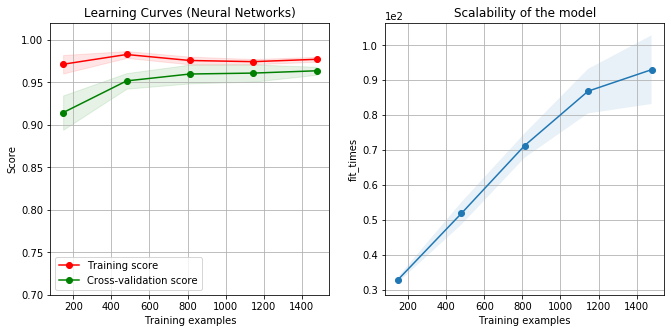

In [74]:
## plot learning curve
cv = 5

fig, axes = plt.subplots(1, 2, figsize=(11, 5))
title = r"Learning Curves (Neural Networks)"

plot_learning_curve(nn_gd, title, X_train_scaled, y_train_hot, axes=axes, ylim=(0.7, 1.02),
                    cv=cv, scoring='accuracy', n_jobs=2)

plt.show()

# RHC

In [80]:
fname = './output/nn_gridsearch/nngs_rhc_esitmator_202002291456_13859642.p'
with open(fname, "rb") as f:
    rhc_estimator = pickle.load(f)
    
nn_model = rhc_estimator

In [81]:
print(nn_model)

NeuralNetwork(activation='relu', algorithm='random_hill_climb', bias=True,
              clip_max=5, curve=False, early_stopping=True,
              hidden_nodes=[30, 20], is_classifier=True, learning_rate=0.8,
              max_attempts=100, max_iters=10000, mutation_prob=0.1,
              pop_size=200, random_state=1, restarts=50,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))


In [61]:
# Predict labels for train set and assess accuracy
y_train_pred_hot = nn_model.predict(X_train_scaled)
y_train_pred = one_hot.inverse_transform(y_train_pred_hot)[:,0]

# acc = accuracy_score(y_train_hot, y_train_pred_hot)  

cm = confusion_matrix(y_train, y_train_pred)  # Confusion Matrix
print('CM:\n', cm)

acc = accuracy_score(y_train, y_train_pred) # Accuracy Score
print('ACC', acc)

f1 = f1_score(y_train, y_train_pred, average='macro')
print('F1', f1)

label = np.unique(y_train_pred)
print(precision_recall_fscore_support(y_train, y_train_pred, average='macro'))
print(precision_score(y_train, y_train_pred, average='micro', labels=label))
print(balanced_accuracy_score(y_train, y_train_pred))


CM:
 [[273   0   0   0   0   0   0]
 [  0 253   0   0   0   0   0]
 [  0   0 238   4  13   0   0]
 [  1   0   0 269   7   0   0]
 [  0   0  25   9 233   0   0]
 [  0   0   0   0   0 257   0]
 [  0   0   0   0   0   0 266]]
ACC 0.9680735930735931
F1 0.967953932489879
(0.9680203795090885, 0.9681588061339005, 0.967953932489879, None)
0.9680735930735931
0.9681588061339005


In [82]:
# Predict labels for train set and assess accuracy
y_test_pred_hot = nn_model.predict(X_test_scaled)
y_test_pred = one_hot.inverse_transform(y_test_pred_hot)[:,0]

# acc = accuracy_score(y_train_hot, y_train_pred_hot)  

cm = confusion_matrix(y_test, y_test_pred)  # Confusion Matrix
print('CM:\n', cm)

acc = accuracy_score(y_test, y_test_pred) # Accuracy Score
print('ACC', acc)

f1 = f1_score(y_test, y_test_pred, average='macro')
print('F1', f1)

label = np.unique(y_test_pred)
print(precision_recall_fscore_support(y_test, y_test_pred, average='macro'))
print(precision_score(y_test, y_test_pred, average='micro', labels=label))
print(balanced_accuracy_score(y_test, y_test_pred))


CM:
 [[56  0  0  0  1  0  0]
 [ 0 77  0  0  0  0  0]
 [ 0  0 67  0  8  0  0]
 [ 0  0  1 51  1  0  0]
 [ 1  0  7  3 52  0  0]
 [ 0  0  0  0  0 73  0]
 [ 0  0  1  0  0  0 63]]
ACC 0.9502164502164502
F1 0.9496100530261822
(0.9495984585118711, 0.9496893500034903, 0.9496100530261822, None)
0.9502164502164502
0.9496893500034903


# SA

In [83]:
fname = './output/nn_gridsearch/nngs_sa_esitmator_202002291122_38058797.p'
with open(fname, "rb") as f:
    rhc_estimator = pickle.load(f)
    
nn_model = rhc_estimator

In [84]:
print(nn_model)

NeuralNetwork(activation='relu', algorithm='simulated_annealing', bias=True,
              clip_max=5, curve=False, early_stopping=True,
              hidden_nodes=[30, 20], is_classifier=True, learning_rate=0.8,
              max_attempts=50, max_iters=10000, mutation_prob=0.1, pop_size=200,
              random_state=1, restarts=0,
              schedule=ExpDecay(init_temp=1.0, exp_const=0.005, min_temp=0.001))


In [85]:
# Predict labels for train set and assess accuracy
y_train_pred_hot = nn_model.predict(X_train_scaled)
y_train_pred = one_hot.inverse_transform(y_train_pred_hot)[:,0]

# acc = accuracy_score(y_train_hot, y_train_pred_hot)  

cm = confusion_matrix(y_train, y_train_pred)  # Confusion Matrix
print('CM:\n', cm)

acc = accuracy_score(y_train, y_train_pred) # Accuracy Score
print('ACC', acc)

f1 = f1_score(y_train, y_train_pred, average='macro')
print('F1', f1)

label = np.unique(y_train_pred)
print(precision_recall_fscore_support(y_train, y_train_pred, average='macro'))
print(precision_score(y_train, y_train_pred, average='micro', labels=label))
print(balanced_accuracy_score(y_train, y_train_pred))


CM:
 [[269   0   0   0   4   0   0]
 [  0 252   0   1   0   0   0]
 [  5   0 233   3  14   0   0]
 [  2   0   0 249  16  10   0]
 [  2   0  33  12 220   0   0]
 [  0   0   0   6   0 251   0]
 [  0   0   0   0   0   1 265]]
ACC 0.941017316017316
F1 0.9410729219271922
(0.9409345623650793, 0.941557458476875, 0.9410729219271922, None)
0.941017316017316
0.941557458476875


In [86]:
# Predict labels for train set and assess accuracy
y_test_pred_hot = nn_model.predict(X_test_scaled)
y_test_pred = one_hot.inverse_transform(y_test_pred_hot)[:,0]

# acc = accuracy_score(y_train_hot, y_train_pred_hot)  

cm = confusion_matrix(y_test, y_test_pred)  # Confusion Matrix
print('CM:\n', cm)

acc = accuracy_score(y_test, y_test_pred) # Accuracy Score
print('ACC', acc)

f1 = f1_score(y_test, y_test_pred, average='macro')
print('F1', f1)

label = np.unique(y_test_pred)
print(precision_recall_fscore_support(y_test, y_test_pred, average='macro'))
print(precision_score(y_test, y_test_pred, average='micro', labels=label))
print(balanced_accuracy_score(y_test, y_test_pred))


CM:
 [[56  0  0  0  1  0  0]
 [ 0 77  0  0  0  0  0]
 [ 0  0 72  1  2  0  0]
 [ 0  0  3 44  1  5  0]
 [ 1  0  7  2 53  0  0]
 [ 0  0  0  3  0 69  1]
 [ 0  0  0  1  0  0 63]]
ACC 0.9393939393939394
F1 0.9360416117530626
(0.938554573244834, 0.9347850200454365, 0.9360416117530626, None)
0.9393939393939394
0.9347850200454365


# GA

In [87]:
fname = './output/nn_gridsearch/nngs_ga_esitmator_202002291942_14543423.p'
with open(fname, "rb") as f:
    rhc_estimator = pickle.load(f)
    
nn_model = rhc_estimator

In [88]:
print(nn_model)

NeuralNetwork(activation='relu', algorithm='genetic_alg', bias=True, clip_max=5,
              curve=False, early_stopping=True, hidden_nodes=[30, 20],
              is_classifier=True, learning_rate=0.8, max_attempts=200,
              max_iters=500, mutation_prob=0.5, pop_size=2000, random_state=1,
              restarts=0,
              schedule=GeomDecay(init_temp=1.0, decay=0.99, min_temp=0.001))


In [89]:
# Predict labels for train set and assess accuracy
y_train_pred_hot = nn_model.predict(X_train_scaled)
y_train_pred = one_hot.inverse_transform(y_train_pred_hot)[:,0]

# acc = accuracy_score(y_train_hot, y_train_pred_hot)  

cm = confusion_matrix(y_train, y_train_pred)  # Confusion Matrix
print('CM:\n', cm)

acc = accuracy_score(y_train, y_train_pred) # Accuracy Score
print('ACC', acc)

f1 = f1_score(y_train, y_train_pred, average='macro')
print('F1', f1)

label = np.unique(y_train_pred)
print(precision_recall_fscore_support(y_train, y_train_pred, average='macro'))
print(precision_score(y_train, y_train_pred, average='micro', labels=label))
print(balanced_accuracy_score(y_train, y_train_pred))


CM:
 [[185   0   0   0  88   0   0]
 [  0 253   0   0   0   0   0]
 [176   1   6   0  65   2   5]
 [ 59  95   0   0  52  71   0]
 [ 58   0   1   0 143  34  31]
 [ 24  92   2   0  14 125   0]
 [  1   0   1   0   1   0 263]]
ACC 0.5275974025974026
F1 0.4496261314114012
(0.47911722075377206, 0.5302669630333471, 0.4496261314114012, None)
0.5275974025974026
0.5302669630333471


In [90]:
# Predict labels for train set and assess accuracy
y_test_pred_hot = nn_model.predict(X_test_scaled)
y_test_pred = one_hot.inverse_transform(y_test_pred_hot)[:,0]

# acc = accuracy_score(y_train_hot, y_train_pred_hot)  

cm = confusion_matrix(y_test, y_test_pred)  # Confusion Matrix
print('CM:\n', cm)

acc = accuracy_score(y_test, y_test_pred) # Accuracy Score
print('ACC', acc)

f1 = f1_score(y_test, y_test_pred, average='macro')
print('F1', f1)

label = np.unique(y_test_pred)
print(precision_recall_fscore_support(y_test, y_test_pred, average='macro'))
print(precision_score(y_test, y_test_pred, average='micro', labels=label))
print(balanced_accuracy_score(y_test, y_test_pred))


CM:
 [[36  0  0  0 21  0  0]
 [ 0 77  0  0  0  0  0]
 [47  4  1  0 21  1  1]
 [ 9 17  0  0 11 16  0]
 [13  0  0  0 31  9 10]
 [ 5 34  2  0  3 29  0]
 [ 2  0  0  0  0  1 61]]
ACC 0.5086580086580087
F1 0.4212175991180405
(0.42278520603643754, 0.4981944352482642, 0.4212175991180405, None)
0.5086580086580087
0.4981944352482642
